In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
CHECKPOINT_DIR = './checkpoints/checkpoint4/'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BatchSize = 128
LearningRate = 1e-4
# like RCNN expand the crop by 16 pixels
p=16

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [48]:
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']

file_name = 'GTbbox_df.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file'+file_name)
    GTbbox_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file'+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')

    for c in crop_classes:
        print(c)
        j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TRAIN_DIR+c+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                delta_width = p/(COLS-2*p)*width
                delta_height = p/(ROWS-2*p)*height
                xmin_expand = xmin-delta_width
                ymin_expand = ymin-delta_height
                xmax_expand = xmin+width+delta_width
                ymax_expand = ymin+height+delta_height
                assert max(xmin_expand,0)<min(xmax_expand,width_image)
                assert max(ymin_expand,0)<min(ymax_expand,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[image_file,i,a["class"],max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                if a["class"] != c: print(GTbbox_df.tail(1))

    #crop NoF by detections_full_AGNOSTICnms.pkl
    num_NoF_perIm = 10
    
    RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1')
    train_detections_full_AGNOSTICnms = detections_full_AGNOSTICnms[1000:]
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    train_files = test_files[1000:]
    assert len(train_detections_full_AGNOSTICnms) == len(train_files)

    for im in range(len(train_detections_full_AGNOSTICnms)):
        if im%1000 == 0: print(im)
        image_file = train_files[im][:9]+'.jpg'
        image = Image.open(TEST_DIR+image_file)
        width_image, height_image = image.size

        bboxes = []
        detects_im = train_detections_full_AGNOSTICnms[im]
        for i in range(len(detects_im)):
            if detects_im[i,4] >= 0.999 and detects_im[i,2]<width_image and detects_im[i,3]<height_image:
                bboxes.append(detects_im[i,:]) 
        bboxes = np.asarray(bboxes)
        bboxes = bboxes[np.random.choice(bboxes.shape[0], num_NoF_perIm, replace=False), :]

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            GTbbox_df.loc[len(GTbbox_df)]=[image_file,j,'NoF',max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]

    GTbbox_df.to_pickle('../data/'+file_name)    

Loading from fileGTbbox_df.pickle


In [4]:
#train data prepare
train_df, valid_df = train_test_split(GTbbox_df, test_size = 0.2, random_state=1986, stratify=GTbbox_df['crop_class'])

nb_perClass = int(BatchSize / len(FISH_CLASSES)) 
samples_per_epoch=BatchSize*math.ceil(train_df.groupby('crop_class').size()['ALB']/nb_perClass)
  
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BatchSize, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BatchSize, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(row[0], row[1])
            fish = row[3]
            bbox = row[4:8]
            cropped = load_img(TRAIN_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,FISH_CLASSES.index(fish)] = 1
            i += 1
        yield (batch_x, batch_y)

train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


# validation_data (valid_x,valid_y)
df_1 = valid_df[valid_df.crop_class != 'NoF']
l = valid_df.groupby('crop_class').size()
l.pop('NoF')
nb_NoF_valid = math.ceil(l.sum()/10)
df_2 = valid_df[valid_df.crop_class == 'NoF'].sample(n=nb_NoF_valid)
valid_df = pd.concat([df_1,df_2], axis=0)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = os.path.join(row[0], row[1])
    fish = row[3]
    bbox = row[4:8]
    cropped = load_img(TRAIN_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,FISH_CLASSES.index(fish)] = 1
    i += 1


In [5]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs/log4', histogram_freq=0, write_graph=False, write_images=True)


In [6]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
x = Dense(256, init='glorot_normal')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

Epoch 1/30
16128/16128 [==============================] - 228s - loss: 1.8950 - acc: 0.3786 - val_loss: 1.4082 - val_acc: 0.4688
Epoch 2/30
16128/16128 [==============================] - 204s - loss: 1.2847 - acc: 0.5556 - val_loss: 1.2129 - val_acc: 0.5530
Epoch 3/30
16128/16128 [==============================] - 209s - loss: 1.0861 - acc: 0.6233 - val_loss: 1.1506 - val_acc: 0.5769
Epoch 4/30
16128/16128 [==============================] - 207s - loss: 0.9851 - acc: 0.6521 - val_loss: 1.1313 - val_acc: 0.5738
Epoch 5/30
16128/16128 [==============================] - 209s - loss: 0.9024 - acc: 0.6811 - val_loss: 1.1219 - val_acc: 0.5644
Epoch 6/30
16128/16128 [==============================] - 209s - loss: 0.8817 - acc: 0.6869 - val_loss: 1.0193 - val_acc: 0.5998
Epoch 7/30
16128/16128 [==============================] - 209s - loss: 0.8210 - acc: 0.7066 - val_loss: 0.9692 - val_acc: 0.6279
Epoch 8/30
16128/16128 [==============================] - 208s - loss: 0.8229 - acc: 0.7018 - val

In [15]:
# Resnet50
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 38

files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

for layer in model.layers[:start_layer]:
   layer.trainable = False
for layer in model.layers[start_layer:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=300, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/checkpoint4/weights.027-0.7618.hdf5
Epoch 1/300
16128/16128 [==============================] - 406s - loss: 0.5332 - acc: 0.8066 - val_loss: 0.6818 - val_acc: 0.7401
Epoch 2/300
16128/16128 [==============================] - 378s - loss: 0.4196 - acc: 0.8472 - val_loss: 0.5764 - val_acc: 0.7983
Epoch 3/300
16128/16128 [==============================] - 378s - loss: 0.3545 - acc: 0.8697 - val_loss: 0.5207 - val_acc: 0.8202
Epoch 4/300
16128/16128 [==============================] - 378s - loss: 0.3009 - acc: 0.8896 - val_loss: 0.4827 - val_acc: 0.8243
Epoch 5/300
16128/16128 [==============================] - 378s - loss: 0.2537 - acc: 0.9077 - val_loss: 0.4335 - val_acc: 0.8462
Epoch 6/300
16128/16128 [==============================] - 378s - loss: 0.2181 - acc: 0.9204 - val_loss: 0.3878 - val_acc: 0.8784
Epoch 7/300
16128/16128 [==============================] - 378s - loss: 0.1836 - acc: 0.9345 - val_loss: 0.3573 - val_acc: 0.8929
Epoc

KeyboardInterrupt: 

In [6]:
#resume training

files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=300, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/checkpoint4/weights.018-0.1897.hdf5
Epoch 1/300
16128/16128 [==============================] - 395s - loss: 0.0357 - acc: 0.9897 - val_loss: 0.1967 - val_acc: 0.9480
Epoch 2/300
16128/16128 [==============================] - 369s - loss: 0.0349 - acc: 0.9883 - val_loss: 0.1992 - val_acc: 0.9439
Epoch 3/300
16128/16128 [==============================] - 369s - loss: 0.0307 - acc: 0.9909 - val_loss: 0.2121 - val_acc: 0.9501
Epoch 4/300
16128/16128 [==============================] - 369s - loss: 0.0303 - acc: 0.9901 - val_loss: 0.2009 - val_acc: 0.9459
Epoch 5/300
16128/16128 [==============================] - 369s - loss: 0.0283 - acc: 0.9912 - val_loss: 0.1968 - val_acc: 0.9470
Epoch 6/300
16128/16128 [==============================] - 369s - loss: 0.0244 - acc: 0.9922 - val_loss: 0.2240 - val_acc: 0.9459
Epoch 7/300
16000/16128 [============================>.] - ETA: 2s - loss: 0.0269 - acc: 0.9916Epoch 00006: val_loss did not improve



In [5]:
#test prepare

files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
test_model = load_model(files[index])
# print('Loading model from weights.004-0.0565.hdf5')
# test_model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')
test_model_name = files[index].split('/')[-2][-1:]+'_'+files[index].split('/')[-1]

def test_generator(df, datagen = None, batch_size = BatchSize):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_df = batch_df[['image_file','xmin','ymin','xmax','ymax']]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = row[0]
            bbox = row[1:]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        yield(batch_x)
        
test_aug_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

Loading model from checkpoints file ./checkpoints/checkpoint4/weights.018-0.1897.hdf5


In [64]:
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']

file_name = 'GTbbox_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file'+file_name)
    RFCNbbox_RFCNpred_CROPpred_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file'+file_name) 
    nb_augmentation = 1
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=GTbbox_df), val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((GTbbox_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=GTbbox_df,datagen=test_aug_datagen), 
                                                       val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    columns = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
    CROPpred_df = pd.DataFrame(test_preds, columns=columns)
    GTbbox_CROPpred_df = pd.concat([GTbbox_df,CROPpred_df], axis=1)
    GTbbox_CROPpred_df['logloss'] = GTbbox_CROPpred_df.apply(lambda row: -math.log(row[row['crop_class']]), axis=1)
    GTbbox_CROPpred_df.to_pickle('../data/'+file_name) 

#logloss of every fish class
print(GTbbox_CROPpred_df.groupby(['crop_class'])['logloss'].mean())
print(GTbbox_CROPpred_df['logloss'].mean())

Loading from fileGTbbox_CROPpred_df_4_weights.018-0.1897.hdf5_.pickle
crop_class
ALB      0.092762
BET      0.058168
DOL      0.153881
LAG      0.000050
NoF      0.092667
OTHER    0.053169
SHARK    0.014509
YFT      0.039202
Name: logloss, dtype: float64
0.0906983802723201


In [41]:
# RFCNbbox_RFCNpred_df = ['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
#                          'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                          'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']

file_name = 'RFCNbbox_RFCNpred_df.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file'+file_name)
    RFCNbbox_RFCNpred_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file'+file_name)        
    RFCNbbox_RFCNpred_df = pd.DataFrame(columns=['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
                                                  'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
                                                  'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']) 
    RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
        train_file_labels = f.readlines()
    assert len(detections_full_AGNOSTICnms) == len(test_files)

    for im in range(len(detections_full_AGNOSTICnms)):
        if im%1000 == 0: print(im)
        basename = test_files[im][:9]
        if im<1000:
            image_class = '--'
        else:
            for i in range(len(train_file_labels)):
                if train_file_labels[i][:9] == basename:
                    image_class = train_file_labels[i][10:-1]
                    break
        image = Image.open(TEST_DIR+'/'+basename+'.jpg')
        width_image, height_image = image.size
        
        bboxes = []
        detects_im = detections_full_AGNOSTICnms[im]
        for i in range(len(detects_im)):
            if np.max(detects_im[i,5:]) >= CONF_THRESH:
                bboxes.append(detects_im[i,:]) 
        if len(bboxes) == 0:
            ind = np.argmax(np.max(detects_im[:,5:], axis=1))
            bboxes.append(detects_im[ind,:])
        bboxes = np.asarray(bboxes)

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            RFCNbbox_RFCNpred_df.loc[len(RFCNbbox_RFCNpred_df)]=[image_class,basename+'.jpg',j,max(xmin_expand,0),max(ymin_expand,0),
                                                                   min(xmax_expand,width_image),min(ymax_expand,height_image),
                                                                   bbox[4],bbox[5],bbox[6],bbox[7],bbox[8],bbox[9],bbox[10],bbox[11]]   
    
    RFCNbbox_RFCNpred_df.to_pickle('../data/'+file_name)      

Loading from file RFCNbbox_RFCNpred_df.pickle.


In [49]:
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']

file_name = 'RFCNbbox_RFCNpred_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file'+file_name)
    RFCNbbox_RFCNpred_CROPpred_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file'+file_name)  
    nb_augmentation = 5
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df), 
                                                  val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((RFCNbbox_RFCNpred_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df,datagen=test_aug_datagen), 
                                                       val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    columns = ['NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
    CROPpred_df = pd.DataFrame(test_preds, columns=columns)
    RFCNbbox_RFCNpred_CROPpred_df = pd.concat([RFCNbbox_RFCNpred_df,CROPpred_df], axis=1)
    RFCNbbox_RFCNpred_CROPpred_df.to_pickle('../data/'+file_name) 

Loading from fileRFCNbbox_RFCNpred_CROPpred_df_4_weights.018-0.1897.hdf5_.pickle


In [58]:
%%time
# clsMaxAve
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    test_files = f.readlines()
    
test_pred_df = pd.DataFrame(columns=['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT'])  
for j in range(len(test_files)):
    image_file = test_files[j][:-1]+'.jpg'
    test_pred_im_df = RFCNbbox_RFCNpred_CROPpred_df.loc[RFCNbbox_RFCNpred_CROPpred_df['image_file'] == image_file, \
                                                        ['image_class','NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']] 
    image_class = test_pred_im_df.iloc[0]['image_class']
    test_pred_im_df.drop('image_class', axis=1, inplace=True)
    max_score = test_pred_im_df.max(axis=1)
    max_cls = test_pred_im_df.idxmax(axis=1)
    test_pred_im_df['max_score'] = max_score
    test_pred_im_df['max_cls'] = max_cls
    test_pred_im_df['Count'] = test_pred_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = test_pred_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_pred_im_df['max_score']
    test_pred_im_clsMax_df = test_pred_im_df.loc[idx,['NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP', 'Count']]
    test_pred_im_clsMax_array = test_pred_im_clsMax_df.values
    pred = np.average(test_pred_im_clsMax_array[:,:-1], axis=0, weights=test_pred_im_clsMax_array[:,-1], returned=False).tolist()
    if image_class!='--':
        ind = FISH_CLASSES.index(image_class)
        logloss = -math.log(pred[ind]) 
    else:
        logloss = np.nan
    test_pred_im_clsMaxAve = [logloss,image_class,image_file]
    test_pred_im_clsMaxAve.extend(pred)
    test_pred_df.loc[len(test_pred_df)]=test_pred_im_clsMaxAve

0
1000
2000
3000
4000
CPU times: user 45.5 s, sys: 0 ns, total: 45.5 s
Wall time: 45.2 s


In [70]:
RFCNbbox_RFCNpred_CROPpred_df.head()

,image_file,crop_index,crop_class,xmin,ymin,xmax,ymax,NoF,ALB,BET,DOL,LAG,OTHER,SHARK,YFT,logloss
0,img_00003.jpg,0.0,ALB,347.583333,57.083333,759.416667,181.916667,6.489206e-06,0.969763,1.117871e-05,2.424330e-10,9.174884e-12,3.020629e-02,1.702598e-08,1.270562e-05,3.070322e-02
1,img_00003.jpg,1.0,ALB,641.833333,84.666667,1036.166667,229.333333,6.814423e-07,0.999865,7.797667e-06,2.037938e-09,8.445000e-10,9.794024e-05,1.933097e-10,2.848675e-05,1.349540e-04
2,img_00003.jpg,2.0,ALB,794.750000,314.916667,1148.250000,498.083333,1.936975e-10,1.000000,1.935775e-09,3.783655e-14,1.688425e-10,3.202986e-07,3.344335e-14,3.644383e-09,3.576279e-07
3,img_00003.jpg,3.0,ALB,261.666667,98.250000,672.333333,430.750000,8.176493e-05,0.999788,8.794897e-07,3.242014e-12,3.201747e-11,1.254188e-04,1.491632e-10,3.653709e-06,2.116785e-04
4,img_00010.jpg,0.0,ALB,643.083333,406.166667,753.916667,627.833333,1.492690e-10,0.999994,1.492111e-08,1.719669e-14,2.209954e-13,5.002722e-06,1.218984e-10,6.676349e-07,5.722062e-06


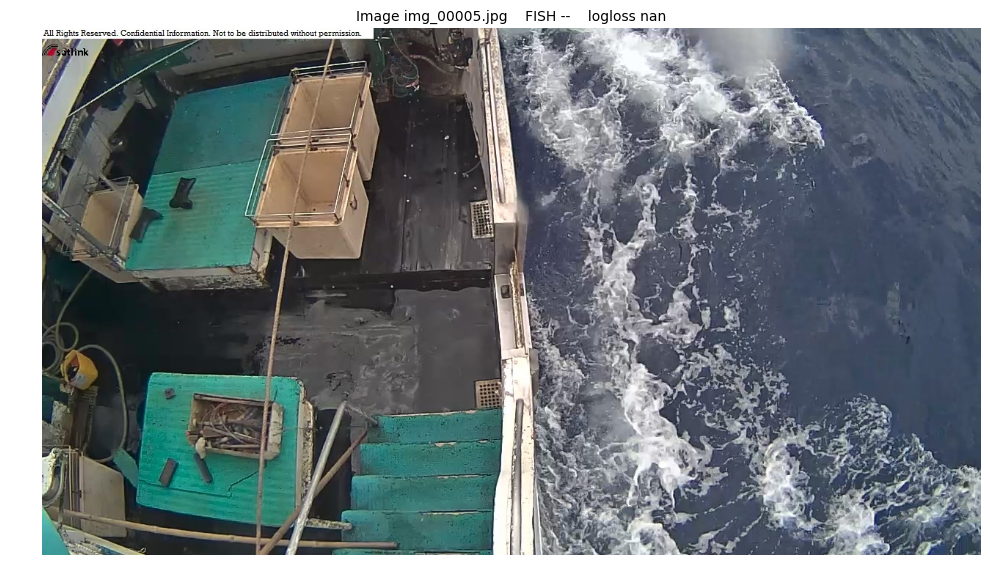

In [73]:
# visualization
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
for j in range(1):
    image_file = test_pred_df.iat[j,2]
    image_class = test_pred_df.iat[j,1]
    image_logloss = test_pred_df.iat[j,0]
    im = Image.open('../RFCN/JPEGImages/'+image_file)
    im = np.asarray(im)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(im, aspect='equal')
    RFCN_dets = RFCNbbox_RFCNpred_CROPpred_df.loc[RFCNbbox_RFCNpred_CROPpred_df['image_file']==image_file]
#     print(RFCN_dets)
    for index,row in RFCN_dets.iterrows():
        row = row.tolist()
        bbox = row[3:7]
        RFCN = row[7:15]
        CROP = row[15:]
        score_RFCN = max(RFCN)
        score_CROP = max(CROP)
        index_RFCN = RFCN.index(score_RFCN)
        index_CROP = CROP.index(score_CROP)
        class_RFCN = FISH_CLASSES[index_RFCN]
        class_CROP = FISH_CLASSES[index_CROP]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
        ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} \nCROP_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_CROP, score_CROP), bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')       
    GT_dets = GTbbox_CROPpred_df.loc[GTbbox_CROPpred_df['image_file']==image_file]
    for index,row in GT_dets.iterrows():
        row = row.tolist()
        bbox = row[3:7]
        CROP = row[7:15]
        score_CROP = max(CROP)
        index_CROP = CROP.index(score_CROP)
        class_CROP = FISH_CLASSES[index_CROP]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
        ax.text(bbox[0], bbox[3] + 40, 'GT_{:s} \nCROP_{:s} {:.3f}'.format(row[2], class_CROP, score_CROP), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')
    ax.set_title(('Image {:s}    FISH {:s}    logloss {}').format(image_file, image_class, image_logloss), fontsize=10) 
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [67]:
#temperature
T = 1
test_pred_array = test_pred_df[FISH_CLASSES].as_matrix()
test_pred_T_array = np.exp(np.log(test_pred_array)/T)
test_pred_T_array = test_pred_T_array/np.sum(test_pred_T_array, axis=1, keepdims=True)
test_pred_T_df = pd.DataFrame(test_pred_T_array, columns=FISH_CLASSES)
test_pred_T_df = pd.concat([test_pred_df[['logloss','image_class','image_file']],test_pred_T_df], axis=1)

#calculate train logloss
print(test_pred_T_df.groupby(['image_class'])['logloss'].mean())
train_logloss = test_pred_T_df['logloss'].mean()
print('logloss of train is', train_logloss )

image_class
--            NaN
ALB      0.071553
BET      0.034714
DOL      0.134487
LAG      0.000026
NoF      0.555833
OTHER    0.011206
SHARK    0.058536
YFT      0.027249
Name: logloss, dtype: float64
logloss of train is 0.11591109204068295


In [68]:
#test submission

submission = test_pred_T_df.iloc[:1000,2:]
submission.rename(columns={'image_file':'image'}, inplace=True)
sub_file = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_CROP_resnet50_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T)+'{:.4f}'.format(train_logloss)+'.csv'
submission.to_csv(sub_file, index=False)
print('Done!'+sub_file)

Done!RFCN_AGONOSTICnms_resnet101_rfcn_ohem_iter_30000_CROP_resnet50_clsMaxAve_conf0.80_T1_0.1159.csv
